In [33]:
%load_ext autoreload
%autoreload 2
import os
from copy import copy
import pickle as pkl
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 250
np.random.seed(0)

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import common

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
DATASET = 'csi'
RESULT_PATH = f'notebooks/transfertree/results/{DATASET}'
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

In [35]:
class TransferTree:
    def __init__(self, model_0, model_1, model_1_log_arr):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_1_log_arr = model_1_log_arr

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        preds_proba[~self.model_1_log_arr] = self.model_0.predict_proba(
            X[~self.model_1_log_arr])
        preds_proba[self.model_1_log_arr] = self.model_1.predict_proba(
            X[self.model_1_log_arr])
        return preds_proba

class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if DATASET == 'tbi' and self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        elif DATASET == 'tbi':
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        elif DATASET == 'csi':
            factors_sum = (
                X['AlteredMentalStatus2'] + X['PainNeck2'] + X['FocalNeuroFindings2'] + 
                X['Torticollis2'] + X['subinj_TorsoTrunk2'] + X['Predisposed'] + 
                X['HighriskDiving'] + X['HighriskMVC']
            )
        elif DATASET == 'iai':
            factors_sum = (
                X['AbdTrauma_or_SeatBeltSign_yes'] + (X['GCSScore'] <= 13).astype(int) + 
                X['AbdTenderDegree_Mild'] + X['AbdTenderDegree_Moderate'] + 
                X['AbdTenderDegree_Severe'] + X['ThoracicTrauma_yes'] + X['AbdomenPain_yes'] +
                X['DecrBreathSound_yes'] + X['VomitWretch_yes']
            )
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

In [36]:
X, y, feature_names = data_util.get_clean_dataset(
    f'{DATASET}_pecarn_pred_old.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

data/imodels_data/csi_pecarn_pred_old.csv


In [37]:
def predict_and_save(model, X_test, y_test, model_name, group):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {}
    for x, y, suffix in zip([X_test],
                            [y_test],
                            ['_tune']):
        stats, threshes = common.all_stats_curve(
            y, model.predict_proba(x)[:, 1], plot=suffix == '_tune', model_name=model_name)
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
        results['acc'] = metrics.accuracy_score(y, model.predict(x))
        results['f1'] = metrics.f1_score(y, model.predict(x))
        if type(model) not in {TransferTree, PECARNModel}:
            results['params'] = model.get_params()
    if not os.path.exists(oj(RESULT_PATH, group)):
        os.mkdir(oj(RESULT_PATH, group))
    print(RESULT_PATH)
    pkl.dump(results, open(oj(RESULT_PATH, group, model_name + '.pkl'), 'wb'))
    return stats, threshes

### training propensity model

In [38]:
X_prop_raw, _, fnames_prop = data_util.get_clean_dataset(
    f'{DATASET}_pecarn_prop_old.csv', data_source='imodels', convertna=False)

data/imodels_data/csi_pecarn_prop_old.csv


In [39]:
X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
X_df_prop_raw['outcome'] = y

if DATASET == 'tbi':
    y_prop = X_df_prop_raw['AgeTwoPlus']
    X_df_prop = X_df_prop_raw.drop(columns=['AgeinYears', 'AgeInMonth', 'AgeTwoPlus', 'outcome'])
    pmodel_all = GradientBoostingClassifier().fit(X_df_prop, y_prop)
elif DATASET == 'csi':
    y_prop = (X_df_prop_raw['AgeInYears'] >= 2).astype(int)
    X_df_prop = X_df_prop_raw.drop(columns=['AgeInYears', 'outcome'])
    pmodel_all = LogisticRegression(C=2.783, penalty='l2', solver='liblinear').fit(X_df_prop, y_prop)
elif DATASET == 'iai':
    y_prop = X_df_prop_raw['Age<2_no']
    X_df_prop = X_df_prop_raw.drop(columns=['Age', 'Age<2_no', 'Age<2_yes', 'outcome'])
    pmodel_all = LogisticRegression(C=0.1, penalty='l2', solver='liblinear').fit(X_df_prop, y_prop)

pscores_all = pmodel_all.predict_proba(X_df_prop)[:, 1]

### data setup

In [40]:
if DATASET == 'csi':
    is_group_1 = (X_df['AgeInYears'] >= 2).astype(bool)
    X_df_clean = X_df
elif DATASET == 'tbi':
    is_group_1 = X_df['AgeTwoPlus'].astype(bool)
    X_df_clean = X_df.drop(columns=['AgeinYears'])
elif DATASET == 'iai':
    is_group_1 = X_df['Age<2_no'].astype(bool)
    X_df_clean = X_df.drop(columns=['Age<2_no', 'Age<2_yes'])
feature_names = X_df_clean.columns

X_young, X_old = X_df_clean[~is_group_1], X_df_clean[is_group_1]
y_young, y_old = y[~is_group_1], y[is_group_1]

In [41]:
cls_ratio = lambda x: int(pd.Series(x).value_counts()[0.0] / pd.Series(x).value_counts()[1.0])
cls_ratio_all = cls_ratio(y)
sw_all = y * cls_ratio_all + 1

In [42]:
all_model_young = imodels.FIGSClassifier(max_rules=8)
all_model_old = imodels.FIGSClassifier(max_rules=8)
all_model_young.fit(X_df_clean, y, sample_weight=(1 - pscores_all) * sw_all)
all_model_old.fit(X_df_clean, y, sample_weight=pscores_all * sw_all)
all_model_all = TransferTree(all_model_young, all_model_old, is_group_1)

In [43]:
all_model_young.feature_names_ = feature_names
print(all_model_young)

------------
FocalNeuroFindings2 <= 0.500 (Tree #0 root)
	AlteredMentalStatus2 <= 0.500 (split)
		Predisposed <= 0.500 (split)
			Torticollis2 <= 0.500 (split)
				Val: 0.102 (leaf)
				Val: 0.723 (leaf)
			Val: 0.756 (leaf)
		Val: 0.521 (leaf)
	Val: 0.854 (leaf)

	+
HighriskMVC <= 0.500 (Tree #1 root)
	is_ems <= 0.500 (split)
		AxialLoadAnyDoc <= 0.500 (split)
			Val: 0.111 (leaf)
			Val: -0.132 (leaf)
		Val: -0.120 (leaf)
	Val: 0.197 (leaf)

	+
subinj_TorsoTrunk2 <= 0.500 (Tree #2 root)
	Val: -0.023 (leaf)
	Val: 0.225 (leaf)



In [44]:
all_model_old.feature_names_ = feature_names
print(all_model_old)

------------
FocalNeuroFindings2 <= 0.500 (Tree #0 root)
	PainNeck2 <= 0.500 (split)
		AlteredMentalStatus2 <= 0.500 (split)
			Torticollis2 <= 0.500 (split)
				AgeInYears <= 5.180 (split)
					Val: 0.049 (leaf)
					Val: 0.181 (leaf)
				Val: 0.770 (leaf)
			Val: 0.552 (leaf)
		Val: 0.568 (leaf)
	Val: 0.823 (leaf)

	+
PtCompPainHead2 <= 0.500 (Tree #1 root)
	is_ems <= 0.500 (split)
		Val: 0.123 (leaf)
		Val: 0.002 (leaf)
	Val: -0.100 (leaf)

	+
HighriskMVC <= 0.500 (Tree #2 root)
	Val: -0.027 (leaf)
	Val: 0.125 (leaf)



100%|██████████| 32/32 [00:00<00:00, 97.75it/s]


notebooks/transfertree/results/csi


100%|██████████| 19/19 [00:00<00:00, 761.09it/s]


notebooks/transfertree/results/csi


100%|██████████| 50/50 [00:00<00:00, 96.05it/s]


notebooks/transfertree/results/csi


({'sens': [1.0,
   1.0,
   0.9962962962962963,
   0.9962962962962963,
   0.9925925925925926,
   0.9740740740740741,
   0.9722222222222222,
   0.9703703703703703,
   0.9666666666666667,
   0.9666666666666667,
   0.9555555555555556,
   0.9555555555555556,
   0.9555555555555556,
   0.9425925925925925,
   0.9425925925925925,
   0.9388888888888889,
   0.9277777777777778,
   0.9277777777777778,
   0.9259259259259259,
   0.8648148148148148,
   0.8648148148148148,
   0.7814814814814814,
   0.7074074074074074,
   0.7,
   0.6981481481481482,
   0.6814814814814815,
   0.6759259259259259,
   0.6759259259259259,
   0.674074074074074,
   0.674074074074074,
   0.6648148148148149,
   0.5203703703703704,
   0.4666666666666667,
   0.43333333333333335,
   0.4222222222222222,
   0.32592592592592595,
   0.3148148148148148,
   0.31296296296296294,
   0.13703703703703704,
   0.13518518518518519,
   0.12777777777777777,
   0.1259259259259259,
   0.12222222222222222,
   0.11296296296296296,
   0.05,
   0.04814

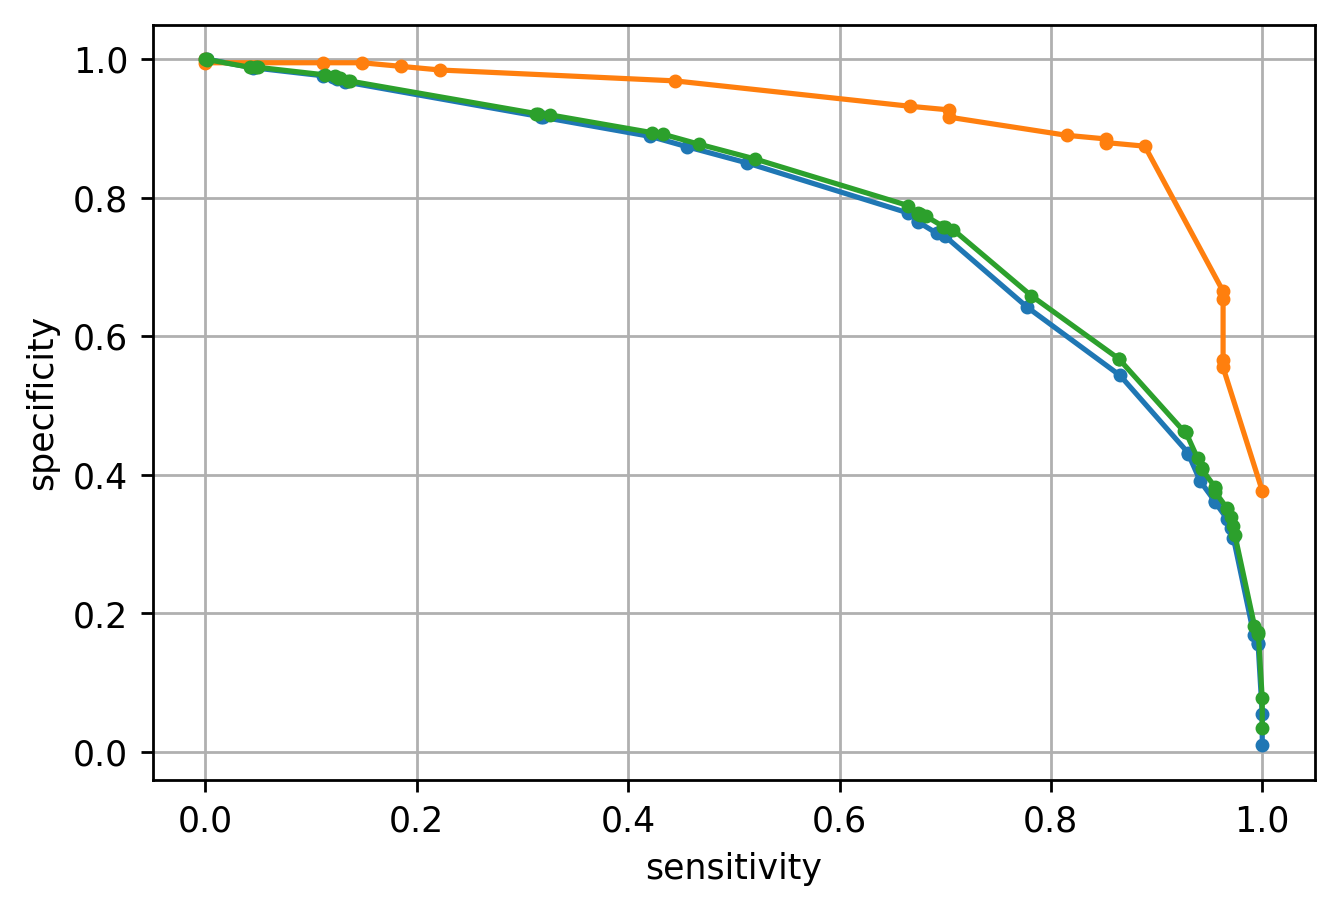

In [45]:
predict_and_save(all_model_old, X_old, y_old, 'pfigs_old', '')
predict_and_save(all_model_young, X_young, y_young, 'pfigs_young', '')
predict_and_save(all_model_all, X_df_clean, y, 'pfigs_all', '')

In [47]:
pkl.dump(all_model_old, open(oj(RESULT_PATH, 'all_model_old.pkl'), 'wb'))
pkl.dump(all_model_young, open(oj(RESULT_PATH, 'all_model_young.pkl'), 'wb'))

## incremental evaluation for CSI

In [47]:
young_trees = copy(all_model_young.trees_)
old_trees = copy(all_model_old.trees_)

In [48]:
all_model_young.trees_ = young_trees[:1]
all_model_old.trees_ = old_trees[:1]
all_model_all = TransferTree(all_model_young, all_model_old, is_group_1)

100%|██████████| 6/6 [00:00<00:00, 97.42it/s]


notebooks/transfertree/results/csi


100%|██████████| 5/5 [00:00<00:00, 565.15it/s]


notebooks/transfertree/results/csi


100%|██████████| 11/11 [00:00<00:00, 87.19it/s]


notebooks/transfertree/results/csi


({'sens': [0.9944444444444445,
   0.9907407407407407,
   0.9407407407407408,
   0.912962962962963,
   0.7481481481481481,
   0.4111111111111111,
   0.4074074074074074,
   0.40555555555555556,
   0.39444444444444443,
   0.012962962962962963,
   0.0],
  'spec': [0.07645149657410746,
   0.12225027046520015,
   0.41038586368553914,
   0.430219978362784,
   0.5953840605842048,
   0.8950595023440318,
   0.8957807428777498,
   0.8968626036783267,
   0.9015506671474937,
   0.9985575189325641,
   1.0],
  'ppv': [0.17333763718528084,
   0.18019535197036038,
   0.23705086327578162,
   0.23781958514230583,
   0.26474442988204455,
   0.4327485380116959,
   0.43222003929273084,
   0.43366336633663366,
   0.4382716049382716,
   0.6363636363636364,
   nan],
  'npv': [0.986046511627907,
   0.9854651162790697,
   0.9726495726495726,
   0.9620967741935483,
   0.9238947957470621,
   0.8864285714285715,
   0.8858773181169758,
   0.8856837606837606,
   0.8843296781039972,
   0.8385826771653543,
   0.8370057

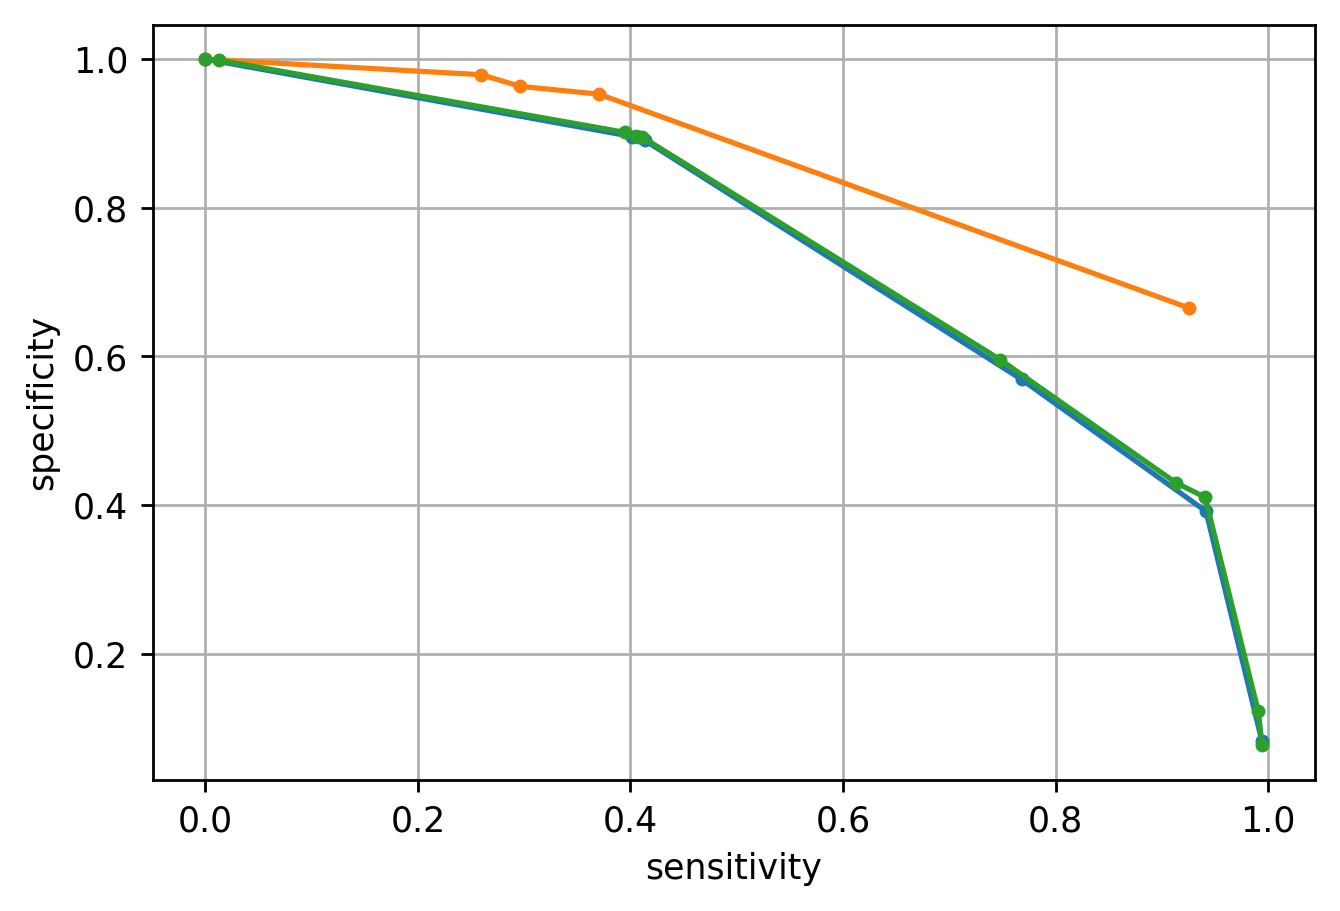

In [49]:
predict_and_save(all_model_old, X_old, y_old, 'pfigs_old_tree_1', '')
predict_and_save(all_model_young, X_young, y_young, 'pfigs_young_tree_1', '')
predict_and_save(all_model_all, X_df_clean, y, 'pfigs_all_tree_1', '')

In [50]:
all_model_young.trees_ = young_trees[:2]
all_model_old.trees_ = old_trees[:2]
all_model_all = TransferTree(all_model_young, all_model_old, is_group_1)

100%|██████████| 18/18 [00:00<00:00, 69.50it/s]


notebooks/transfertree/results/csi


100%|██████████| 13/13 [00:00<00:00, 622.34it/s]


notebooks/transfertree/results/csi


100%|██████████| 30/30 [00:00<00:00, 92.33it/s]


notebooks/transfertree/results/csi


({'sens': [1.0,
   0.9981481481481481,
   0.9907407407407407,
   0.987037037037037,
   0.9555555555555556,
   0.9518518518518518,
   0.9518518518518518,
   0.9407407407407408,
   0.9407407407407408,
   0.9351851851851852,
   0.9166666666666666,
   0.8388888888888889,
   0.7018518518518518,
   0.5944444444444444,
   0.5925925925925926,
   0.587037037037037,
   0.587037037037037,
   0.587037037037037,
   0.5777777777777777,
   0.42592592592592593,
   0.40925925925925927,
   0.30925925925925923,
   0.29814814814814816,
   0.2962962962962963,
   0.07962962962962963,
   0.07777777777777778,
   0.07592592592592592,
   0.06666666666666667,
   0.001851851851851852,
   0.0],
  'spec': [0.03714388748647674,
   0.09267940858276236,
   0.19870176703930761,
   0.20915975477821855,
   0.3671114316624594,
   0.37973314100252437,
   0.3862243058059863,
   0.41038586368553914,
   0.4111071042192571,
   0.42589253516047604,
   0.4673638658492607,
   0.5863685539127299,
   0.6996033177064551,
   0.809231

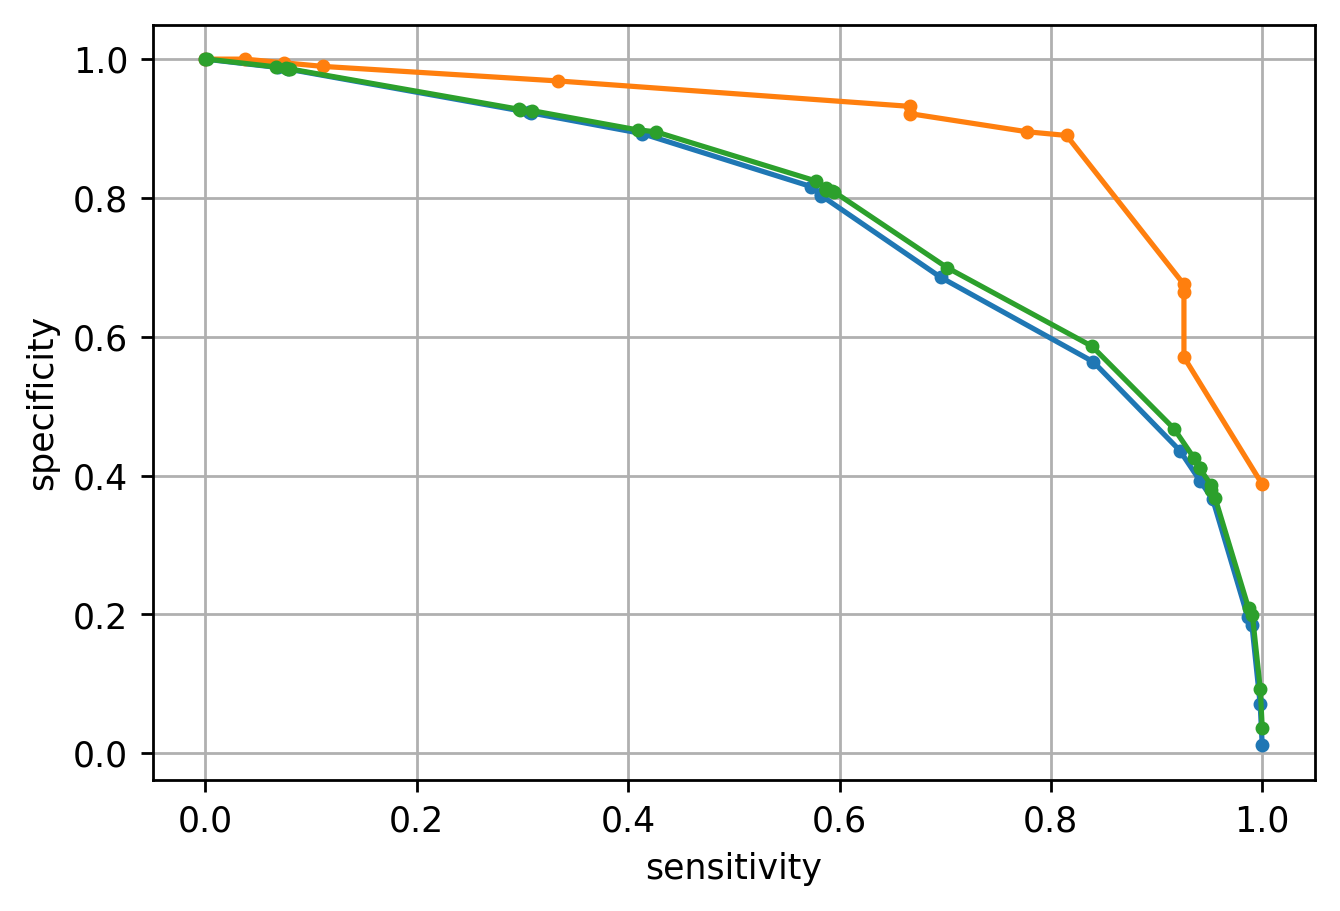

In [51]:
predict_and_save(all_model_old, X_old, y_old, 'pfigs_old_tree_2', '')
predict_and_save(all_model_young, X_young, y_young, 'pfigs_young_tree_2', '')
predict_and_save(all_model_all, X_df_clean, y, 'pfigs_all_tree_2', '')